In [25]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as stats


# Prepare loss function

In [26]:
def obstacle_penalty(observation, penalty_factor):
    """
    Calculates the value of probability density function of a bivariate normal distribution at a given point.
    Arguments:
    x, y : float
        Coordinates of the point at which to calculate the probability density value.
    mu_x, mu_y : float
        Mean values (expectations) along the X and Y axes, respectively.
    sigma_x, sigma_y : float
        Standard deviations along the X and Y axes, respectively.
    rho : float
        Correlation coefficient between X and Y.

    Returns:
    float
        Value of the probability density function of a bivariate normal distribution at the given point (x, y).
    """
    mu_x = obstacle_x = -0.5
    sigma_x = obstacle_sigma = 0.2

    mu_y = obstacle_y = -0.5
    sigma_y = obstacle_sigma = 0.2
    rho = 0
    x = observation[0]
    y = observation[1]
    z = ((x - mu_x) ** 2) / (sigma_x ** 2) + ((y - mu_y) ** 2) / (sigma_y ** 2) - (2 * rho * (x - mu_x) * (y - mu_y)) / (sigma_x * sigma_y)
    denom = 2 * np.pi * sigma_x * sigma_y * np.sqrt(1 - rho ** 2)
    return np.exp(-z / (2 * (1 - rho ** 2))) / denom * penalty_factor

In [27]:
x_lim = y_lim = [-1, 0]
X = np.arange(x_lim[0], x_lim[1], 0.01)
Y = np.arange(y_lim[0], y_lim[1], 0.01)

X, Y = np.meshgrid(X, Y)
Z = []
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z.append(obstacle_penalty(observation=[X[i, j], Y[i, j]], penalty_factor=1e2))

Z = np.array(Z).reshape((X.shape[0], X.shape[1]))
# len(Z)

In [28]:
linestyle_dict = {
     'loosely dotted': (0, (1, 10)),
     'dotted': (0, (1, 1)),
     'densely dotted': (0, (1, 1)),
     'long dash with offset': (5, (10, 3)),
     'loosely dashed': (0, (5, 10)),
     'dashed': (0, (5, 5)),
     'densely dashed': (0, (5, 1)),
     'loosely dashdotted': (0, (3, 10, 1, 10)),
     'dashdotted': (0, (3, 5, 1, 5)),
     'densely dashdotted': (0, (3, 1, 1, 1)),
     'dashdotdotted': (0, (3, 5, 1, 5, 1, 5)),
     'loosely dashdotdotted': (0, (3, 10, 1, 10, 1, 10)),
     'densely dashdotdotted': (0, (3, 1, 1, 1, 1, 1)),
     'solid': 'solid'
}
style = {
            1: "dotted", 
            5: "solid", 
            10: "dashed", 
            50: "dashdotted", 
            100: "loosely dashdotted"
        }

colors = {
            1: "tab:orange", 
            5: "tab:blue", 
            10: "tab:green", 
            50: "tab:red", 
            100: "tab:purple"
        }

# Get experiment information

## Load experiments

In [29]:
# data_dir = "regelum_data/outputs/2024-07-23/12-21-55/0/.callbacks/HistoricalDataCallback"
# data_dir = "regelum_data/outputs/2024-07-24/12-17-15/0/.callbacks/HistoricalDataCallback"
data_dir = "regelum_data/outputs/2024-07-25/13-36-48"
data_dir = "regelum_data/outputs/2024-07-25/15-34-05"
data_dir = "regelum_data/outputs/2024-08-01/10-03-43"

# runs in hyperparameters sections
data_dir = "regelum_data/outputs/2024-08-01/10-03-43"
ref_dir = "regelum_data/outputs/2024-07-25/11-15-03/0/.callbacks/HistoricalDataCallback"


# CALF with quad-nomix
data_dir = "regelum_data/outputs/2024-08-06/08-46-07"
data_dir = "regelum_data/outputs/2024-08-06/11-47-58" # Apply slow down
ref_dir = "regelum_data/outputs/2024-08-06/08-57-20" # Not apply slow down
ref_dir = "regelum_data/outputs/2024-08-06/10-12-06" # Apply slow down

# CALF gazebo in LAB Server
## spot penalty = 1e2
data_dir = "regelum_data/outputs/2024-08-06/13-29-51"
ref_dir = "regelum_data/outputs/2024-08-06/12-50-11"
## spot penalty = 1e3
data_dir = "regelum_data/outputs/2024-08-06/14-54-38"
ref_dir = "regelum_data/outputs/2024-08-06/15-15-59"

data_dir = "regelum_data/outputs/2024-08-06/16-27-05"
ref_dir = "regelum_data/outputs/2024-08-06/16-23-54"

def get_df_from_folder(data_dir):
    df_list = []
    for root, dirs, files in os.walk(data_dir):
        if not root.endswith("HistoricalDataCallback"):
            continue

        for fn in files:
            if not fn.endswith(".h5"):
                continue

            file_path = os.path.join(root, fn)
            df = pd.read_hdf(file_path, key="data")
            df["file_name"] = fn
            df["seed"] = os.path.basename(os.path.dirname(os.path.dirname(root)))
            df["dis_2_goal"] = df.apply(lambda row: np.linalg.norm([row["x [m]"], row["y [m]"]]), axis=1)
            df_list.append(df)

    concat_df = pd.concat(df_list) if len(df_list) else pd.DataFrame()
    return concat_df

concat_df = get_df_from_folder(data_dir)
concat_df.head()

,time,running_objective,current_value,episode_id,iteration_id,velocity [m/s],angular velocity [rad/s],x [m],y [m],angle [rad],use_calf,critic_new,critic_safe,critic_low_kappa,critic_up_kappa,calf_diff,file_name,seed,dis_2_goal
0,0.000000,1.066799,10.667993,1,1,-0.057211,-0.640327,-1.000000,-1.000000,3.141593,1,11850.021937,13154.389375,1.186960,11869.604401,-1304.367437,observations_actions_it_00001.h5,0,1.414214
1,0.103005,2.034189,9.673892,1,1,0.141427,1.295191,-1.000176,-0.999900,0.000326,0,2000.152094,11850.021937,0.200015,2000.152056,-9849.869843,observations_actions_it_00001.h5,0,1.414267
2,0.265166,2.956444,9.222551,1,1,0.220000,0.105882,-1.005236,-0.999775,-0.053148,1,1993.220543,11850.021937,0.201287,2012.873618,-9856.801394,observations_actions_it_00001.h5,0,1.417762
3,0.462539,3.836025,8.795814,1,1,0.220000,0.251168,-1.010631,-0.999305,-0.125584,1,1993.210543,1993.220543,0.203576,2035.757890,-0.010000,observations_actions_it_00001.h5,0,1.421262
4,0.563545,4.761451,9.254264,1,1,0.220000,0.176148,-1.004718,-0.999945,-0.088074,1,1993.200543,1993.210543,0.201710,2017.104576,-0.010000,observations_actions_it_00001.h5,0,1.417515


## Get Nomial reference

In [30]:
ref_df = get_df_from_folder(ref_dir)
ref_df.head()

,time,running_objective,current_value,episode_id,iteration_id,velocity [m/s],angular velocity [rad/s],x [m],y [m],angle [rad],use_calf,critic_new,critic_safe,critic_low_kappa,critic_up_kappa,calf_diff,file_name,seed,dis_2_goal
0,0.000000,1.066799,10.667993,1,1,-0.141421,-2.840000,-1.000000,-1.000000,3.141593,0,11850.021937,13154.389375,1.186960,11869.604401,-1304.367437,observations_actions_it_00001.h5,0,1.414214
1,0.100300,2.034903,9.681032,1,1,0.141421,1.295777,-1.000100,-0.999900,-0.000024,0,2000.000782,13154.389375,0.200000,2000.000001,-11154.388592,observations_actions_it_00001.h5,0,1.414214
2,0.309868,2.944449,9.095462,1,1,0.141880,1.517459,-1.007062,-0.999405,-0.151899,0,2036.056395,13154.389375,0.203606,2036.055971,-11118.332980,observations_actions_it_00001.h5,0,1.418796
3,0.452991,3.810895,8.664461,1,1,0.142244,1.781148,-1.013816,-0.997759,-0.332275,0,2133.752797,13154.389375,0.213375,2133.752791,-11020.636578,observations_actions_it_00001.h5,0,1.422444
4,0.584762,4.704973,8.940783,1,1,0.142015,1.818544,-1.008696,-0.999674,-0.353366,0,2141.683260,13154.389375,0.214168,2141.682961,-11012.706115,observations_actions_it_00001.h5,0,1.420146


# Plot validation images

In [31]:
concat_df.head()
concat_df["iteration_id"].max()

def filter_on_target_df(df):
    dis_2_goal_df = df.loc[:, ["seed", "iteration_id", "dis_2_goal"]].groupby(["seed", "iteration_id"]).agg("min")
    on_target_runs = dis_2_goal_df[dis_2_goal_df < 0.04].dropna().index
    on_target_records = df.apply(lambda row: (row["seed"], row["iteration_id"]) in on_target_runs, axis=1)
    return df[on_target_records]

clean_df = filter_on_target_df(concat_df)
clean_df.loc[:, ["seed", "iteration_id", "current_value"]].groupby(["seed", "iteration_id"]).agg("max").sort_values(by="current_value")

,,current_value
seed,iteration_id,
0,1,2998.947466


In [32]:
def plot_trajectories_given_trajectory(df, ref_df=None):
    seeds =  df["seed"].unique()

    fig, ax = plt.subplots(sharey=True, figsize=(6, 6))

    cs = ax.contourf(X, Y, Z, alpha=1, levels=10, cmap="BuPu")
    cs.cmap.set_over('red')
    cs.cmap.set_under('blue')
    cs.changed()

    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in cs.collections]


    for seed in seeds:
        sub_df_1 = df[df["seed"] == seed]
        trials = list(sub_df_1["file_name"].unique())
        trials.sort()

        for param_trial in trials:
            sub_df_2 = sub_df_1[sub_df_1["file_name"] == param_trial]
            alpha = (sub_df_2["iteration_id"].max()/sub_df_1["iteration_id"].max())

            ax.plot(sub_df_2["x [m]"], sub_df_2["y [m]"], 
                    linestyle=linestyle_dict[style[1]],
                    lw=1, 
                    color=colors[5] if sub_df_2["iteration_id"].max() <= sub_df_1["iteration_id"].max() - 1 else colors[50], 
                    alpha=alpha)
        
    if ref_df is not None:
        ax.plot(ref_df["x [m]"], ref_df["y [m]"], 
                linestyle=linestyle_dict[style[5]],
                lw=2, 
                color=colors[10], 
                alpha=1,
                label="Nominal")

    traj_legend = ax.legend()
    ax.legend(proxy, 
                 [f"{cs.levels[l_i-1]} - {cs.levels[l_i]}" for l_i in range(1, len(cs.levels))],
                 bbox_to_anchor=(1, 1))
    
    ax.add_artist(traj_legend)

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    
    # Show the plot
    ax.grid(True)

    fig.savefig("media/trajectories.svg", dpi=fig.dpi)

# plot_trajectories_given_trajectory(concat_df)

/tmp/ipykernel_61581/198938055.py:11: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in cs.collections]


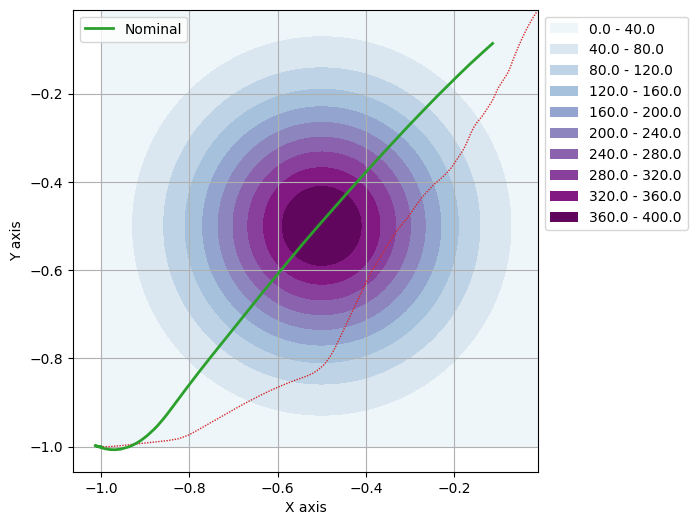

In [33]:
plot_trajectories_given_trajectory(clean_df, ref_df)

/tmp/ipykernel_61581/4271247548.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend(bbox_to_anchor=(1, 1))


('0', 1)

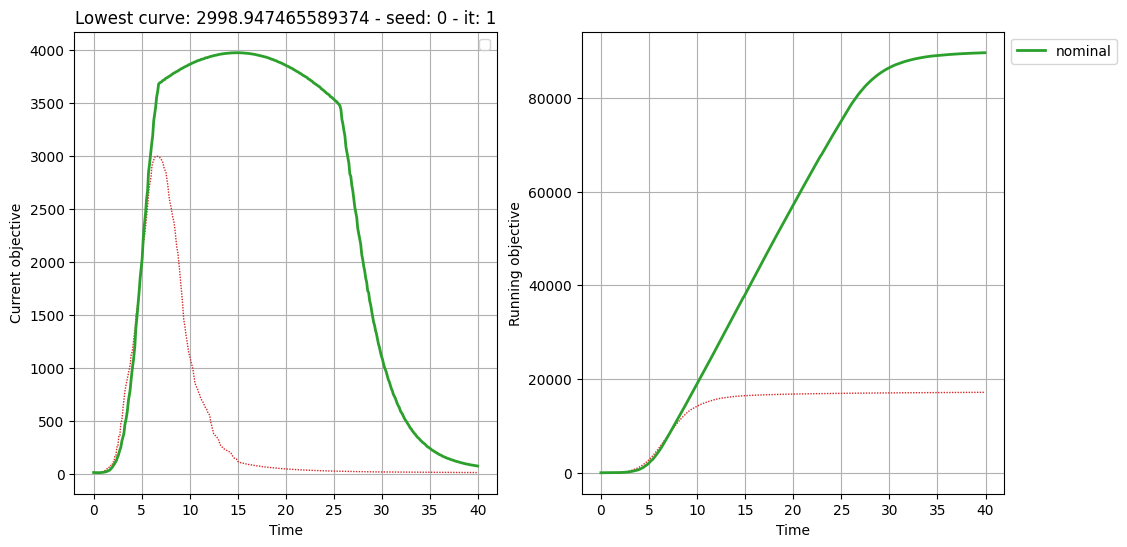

In [34]:
def plot_objective(df, ref_df=None):
    seeds = df["seed"].unique()
    lowest_current_value_runs = clean_df.loc[:, ["seed", "iteration_id", "current_value"]].groupby(["seed", "iteration_id"]).agg("max").sort_values(by="current_value")
    lowest_current_value = lowest_current_value_runs.values[0, 0]
    lowest_current_value_info = lowest_current_value_runs.index[0]

    fig, ax = plt.subplots(1,2,sharey=False, figsize=(12, 6))

    for seed in seeds:
        sub_df_1 = df[df["seed"] == seed]
        trials = list(sub_df_1["file_name"].unique())
        trials.sort()

        for param_trial in trials:
            sub_df_2 = sub_df_1[sub_df_1["file_name"] == param_trial]
            last_alpha = False
            if last_alpha:
                alpha = (sub_df_2["current_value"].max()/sub_df_1["current_value"].max())
            else:
                lowest_current_value
            #     rv = stats.norm(loc=lowest_current_value, scale=5)
                rv = stats.norm(loc=lowest_current_value, scale=20)
                alpha = rv.pdf(sub_df_2["current_value"].max())*10000
                alpha = np.clip(alpha, 0.5, 1)

            ax[0].plot(sub_df_2["time"], sub_df_2["current_value"], 
                    linestyle=linestyle_dict[style[1]],
                    lw=1, 
                    color=colors[5] if sub_df_2["iteration_id"].max() <= sub_df_1["iteration_id"].max() - 5 else colors[50], 
                    alpha=alpha)
            
            ax[1].plot(sub_df_2["time"], sub_df_2["running_objective"], 
                    linestyle=linestyle_dict[style[1]],
                    lw=1, 
                    color=colors[5] if sub_df_2["iteration_id"].max() <= sub_df_1["iteration_id"].max() - 5 else colors[50], 
                    alpha=alpha)
        
    if ref_df is not None:
        ax[0].plot(ref_df["time"], ref_df["current_value"], 
                linestyle=linestyle_dict[style[5]],
                lw=2, 
                color=colors[10], 
                alpha=1)
        
        ax[1].plot(ref_df["time"], ref_df["running_objective"], 
                linestyle=linestyle_dict[style[5]],
                lw=2, 
                color=colors[10], 
                alpha=1,
                label="nominal")

    ax[0].set_title("Lowest curve: {} - seed: {} - it: {}".format(lowest_current_value, lowest_current_value_info[0], lowest_current_value_info[1]))
    # draw goal pose
    ax[0].legend(bbox_to_anchor=(1, 1))
    ax[1].legend(bbox_to_anchor=(1, 1))

    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Current objective')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Running objective')
    
    # Show the plot
    ax[0].grid(True)
    ax[1].grid(True)

    fig.savefig("media/objectives.svg", dpi=fig.dpi)


plot_objective(clean_df, ref_df)

# concat_df.loc["iteration_id"]
# clean_df.loc[:, ["seed", "iteration_id", "current_value"]].groupby(["seed", "iteration_id"]).agg("max").sort_values(by="current_value").values[0, 0]
clean_df.loc[:, ["seed", "iteration_id", "current_value"]].groupby(["seed", "iteration_id"]).agg("max").sort_values(by="current_value").index[0]

/tmp/ipykernel_61581/4271247548.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend(bbox_to_anchor=(1, 1))


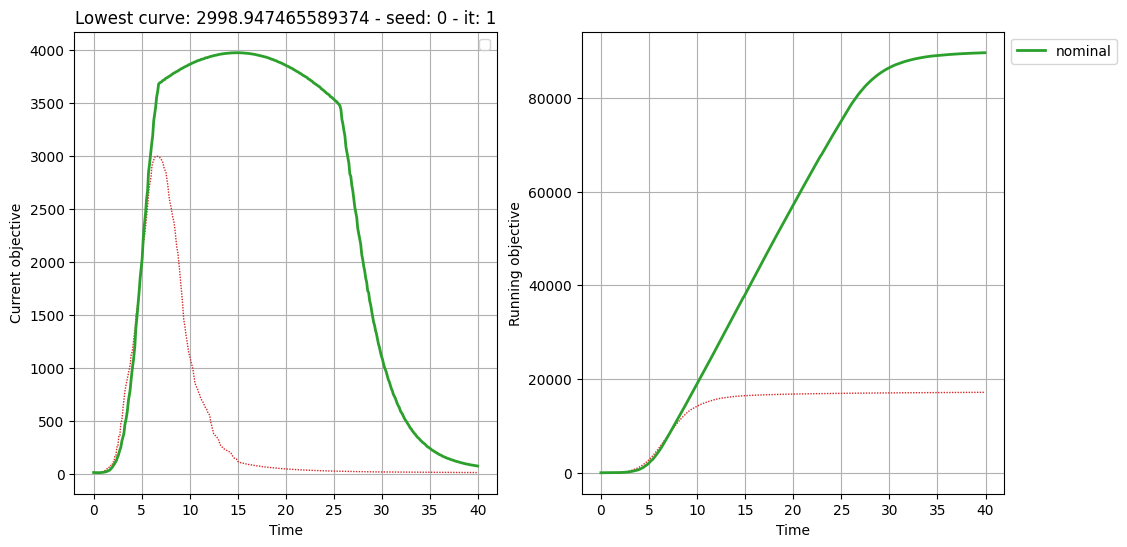

In [35]:
plot_objective(clean_df, ref_df)

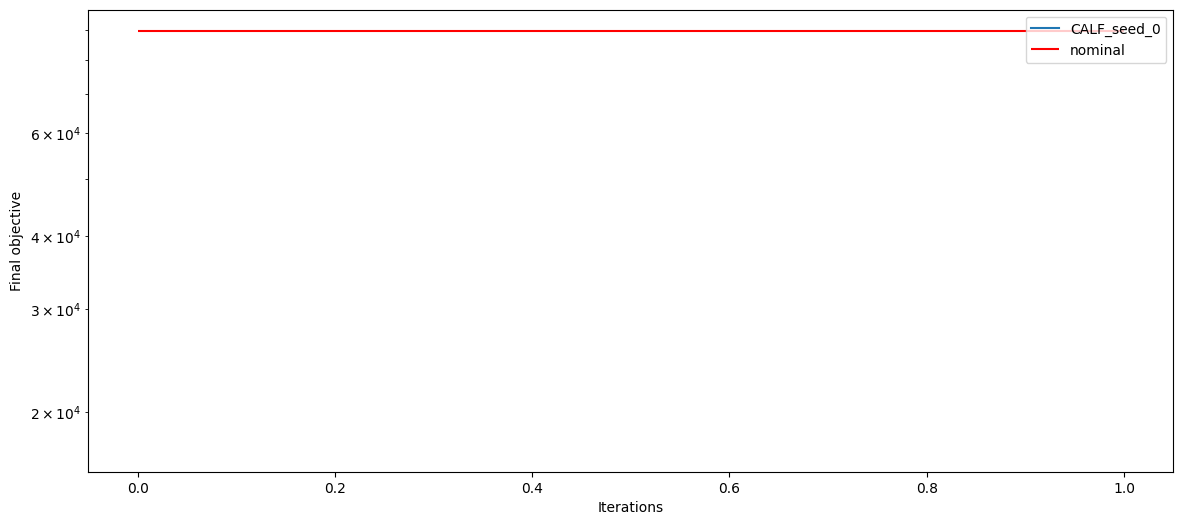

In [36]:
def plot_final_cost(df):
    fig, ax = plt.subplots(figsize=(14, 6))

    seeds = df["seed"].unique()
    for seed in seeds:
        sub_df_1 = df[df["seed"] == seed]
        sub_df_1.groupby("iteration_id")["running_objective"].max().plot(ax=ax, label=f"CALF_seed_{seed}")

    ax.hlines(ref_df["running_objective"].max(), 
            xmin=0, 
            xmax=df["iteration_id"].max(), 
            colors="red",
            label="nominal")

    ax.legend()
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Final objective')
    ax.set_yscale("log")

plot_final_cost(clean_df)

/tmp/ipykernel_61581/1804913831.py:9: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in cs.collections]
/tmp/ipykernel_61581/1804913831.py:9: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in cs.collections]
/tmp/ipykernel_61581/1804913831.py:9: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in cs.collections]
/tmp/ipykernel_61581/1804913831.py:9: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in cs.collections]
/tmp/ipykernel_61581

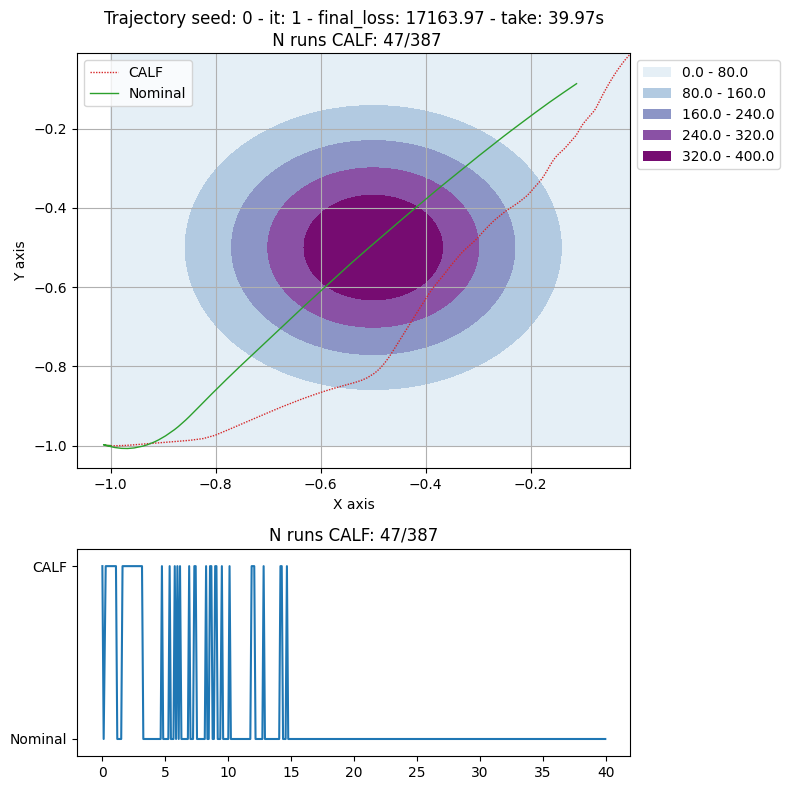

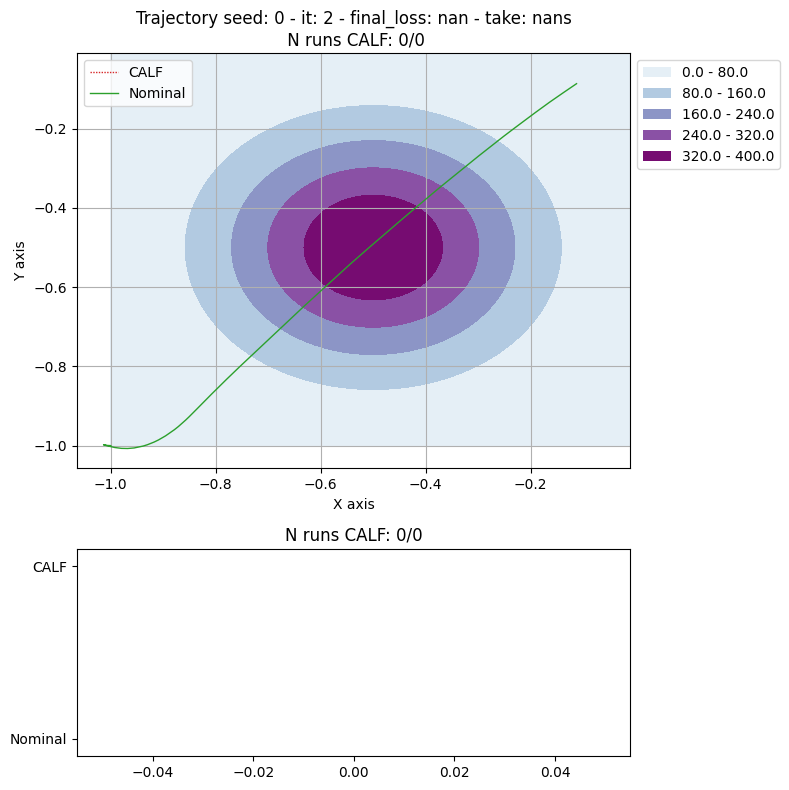

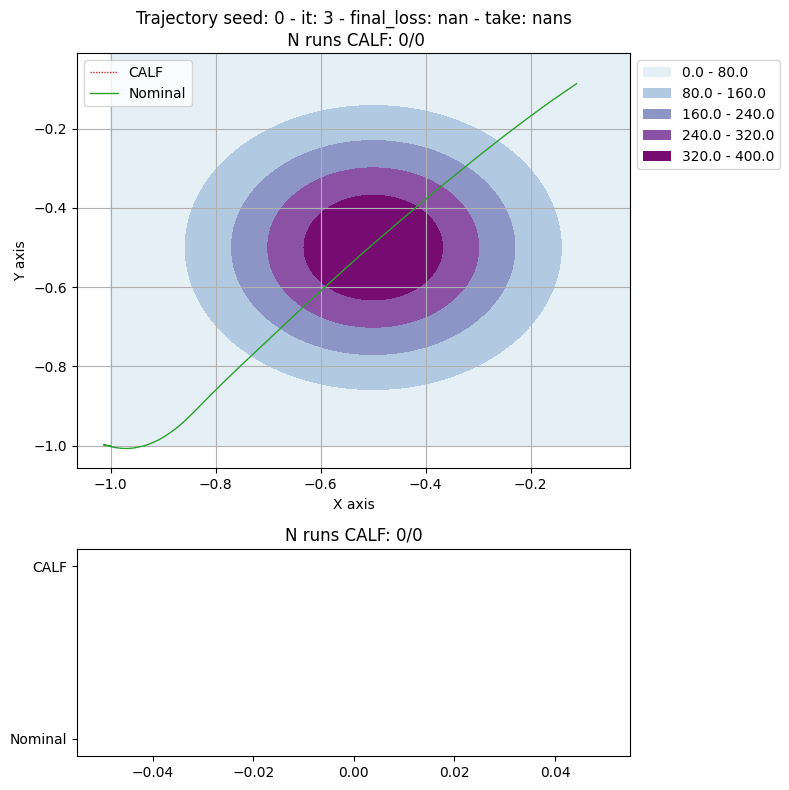

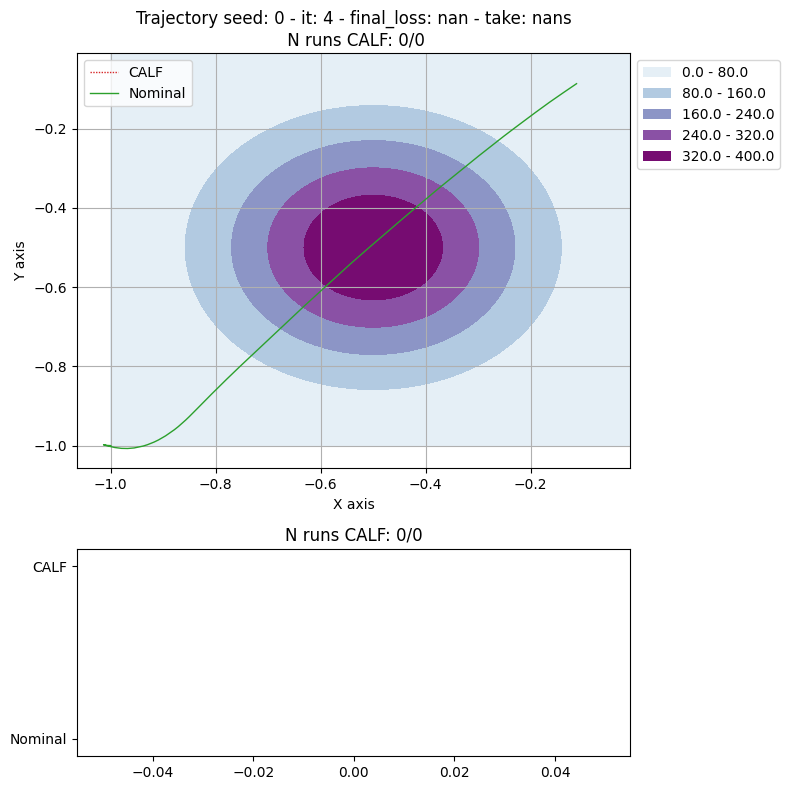

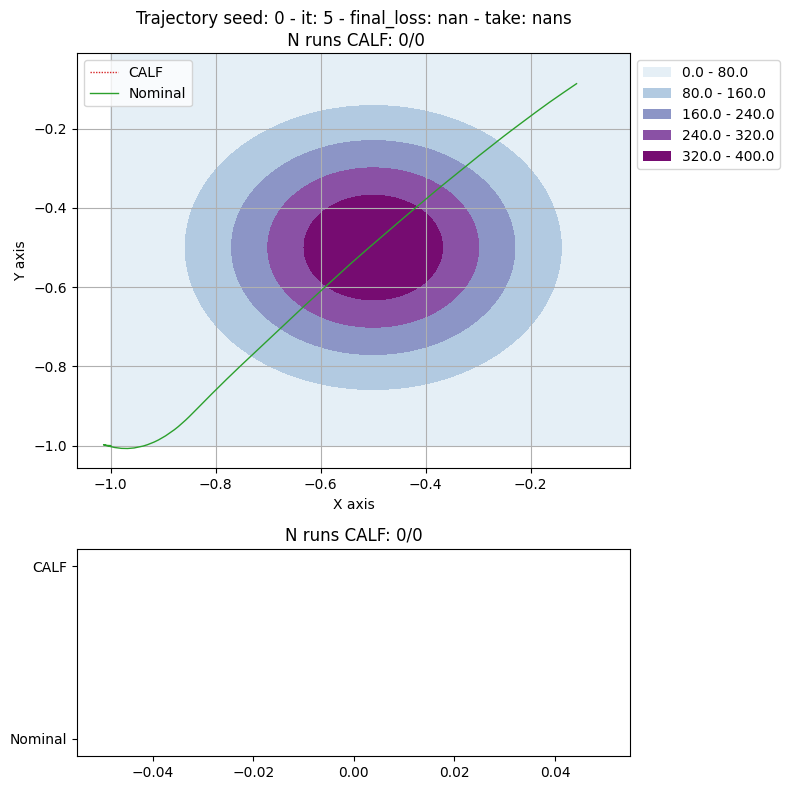

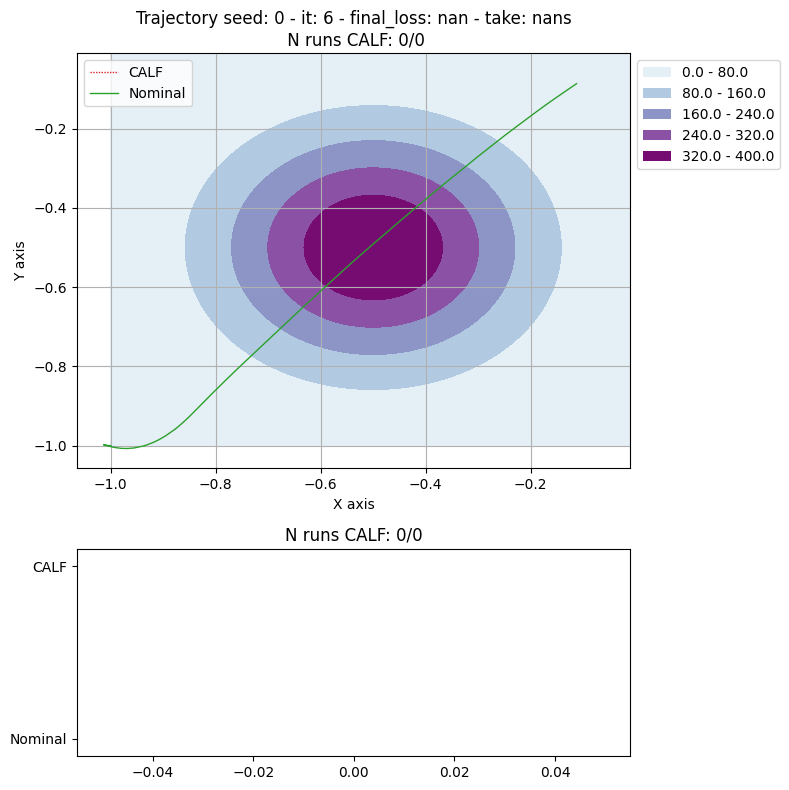

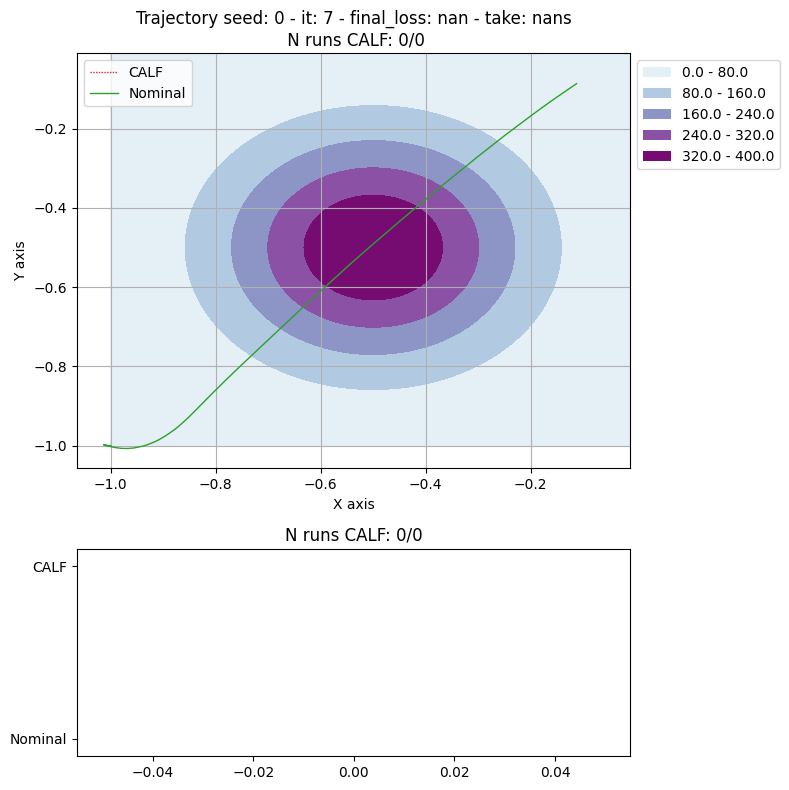

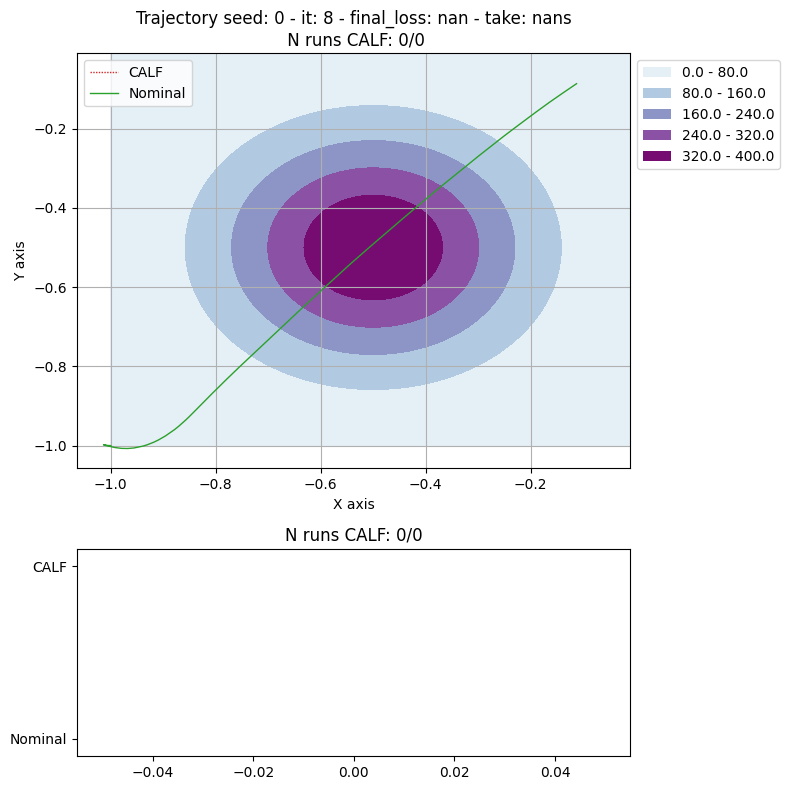

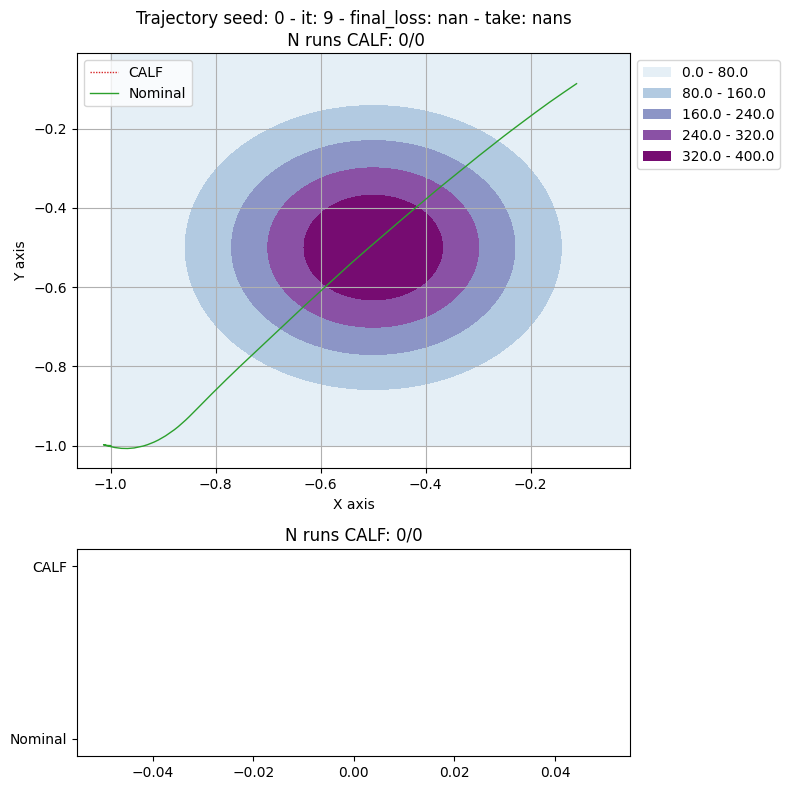

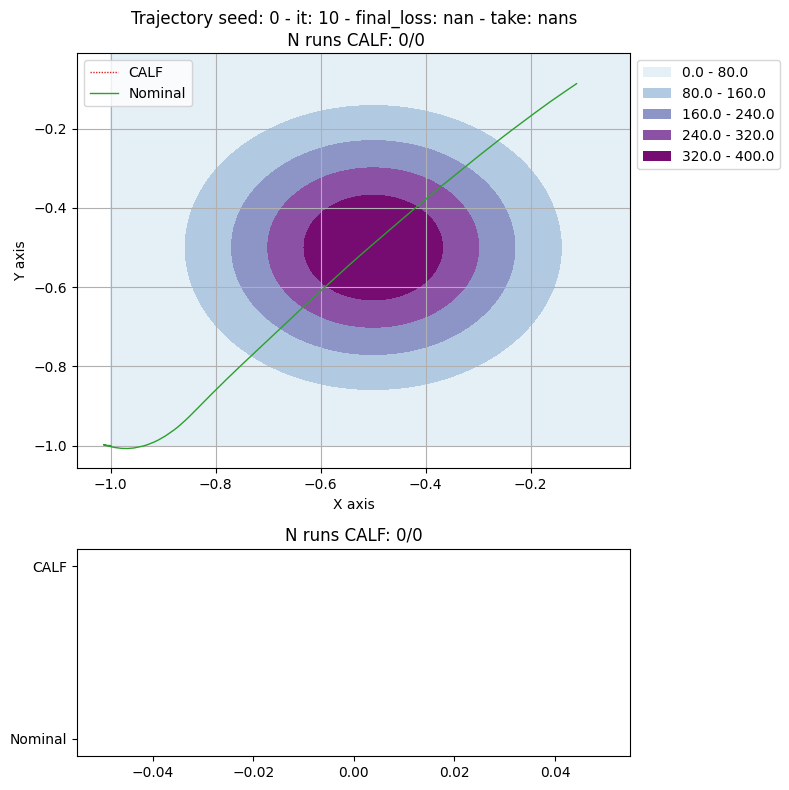

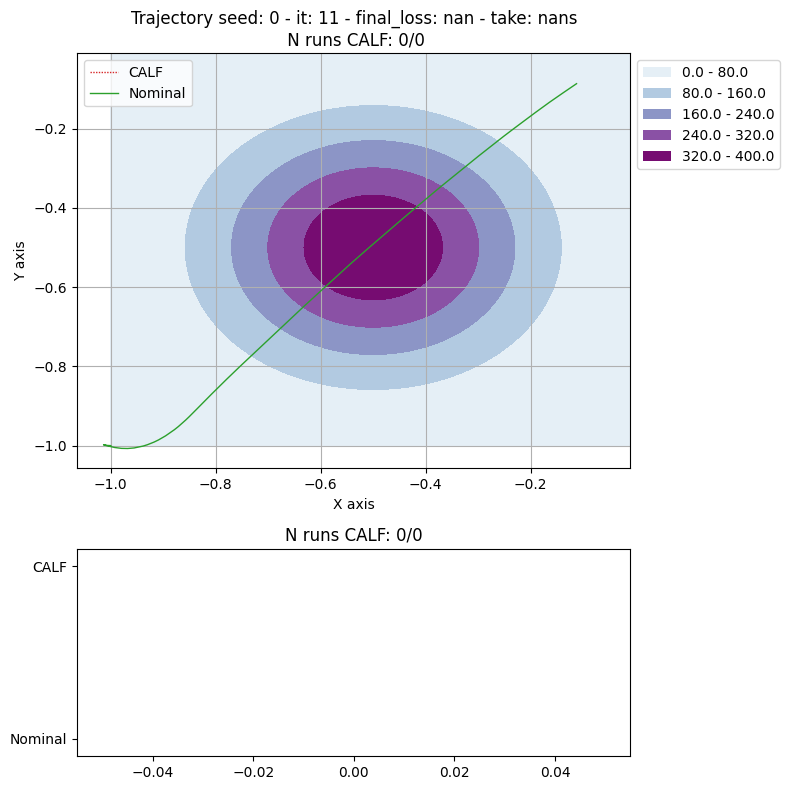

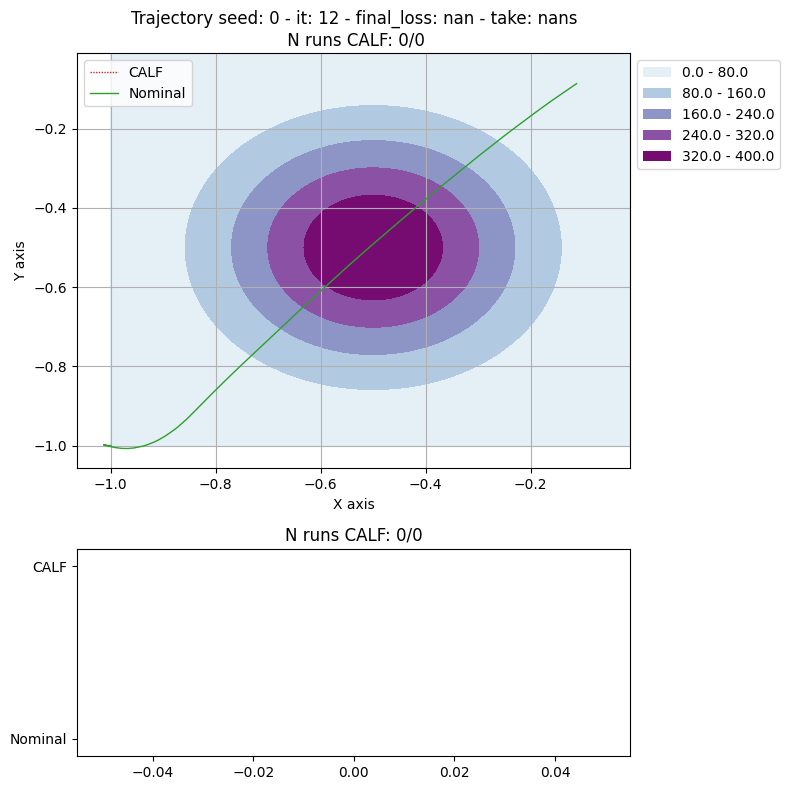

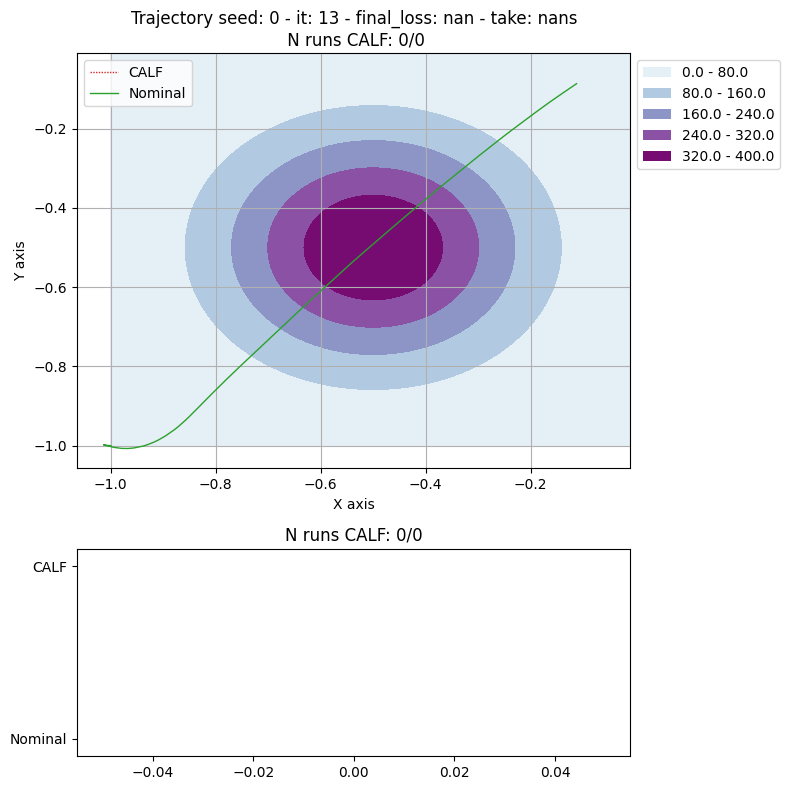

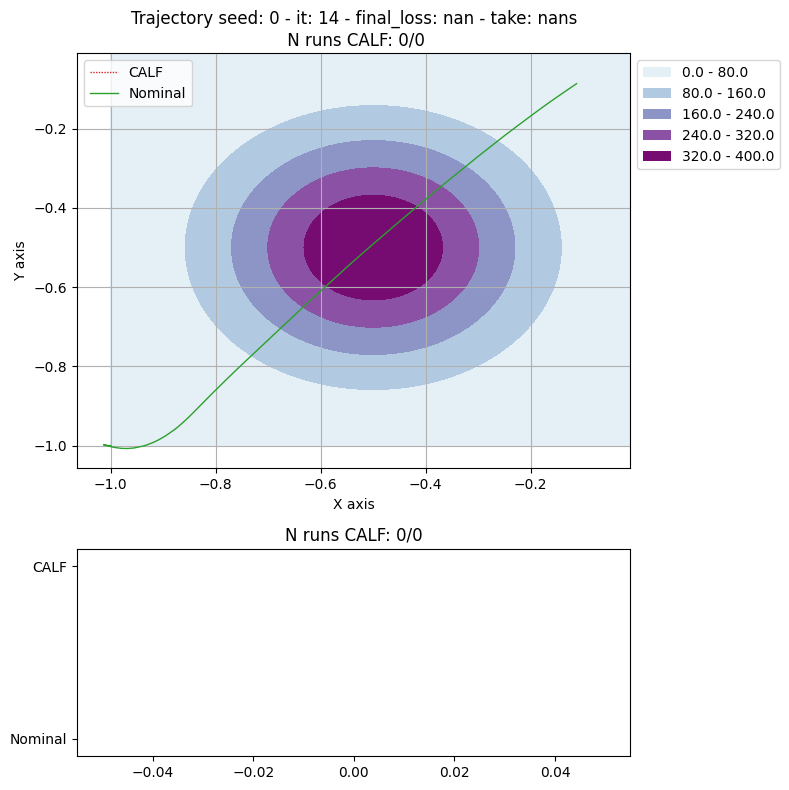

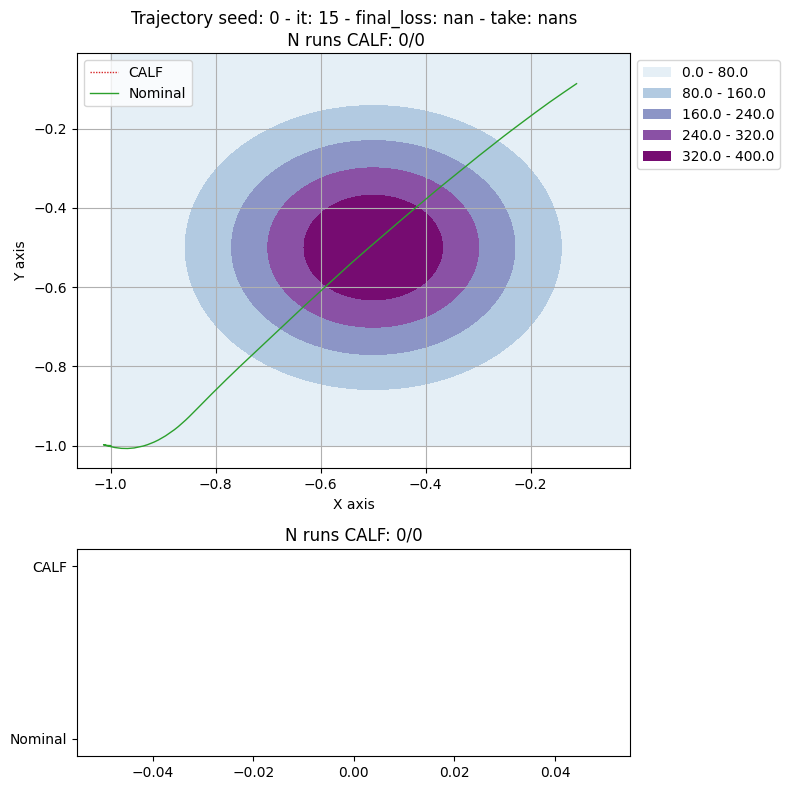

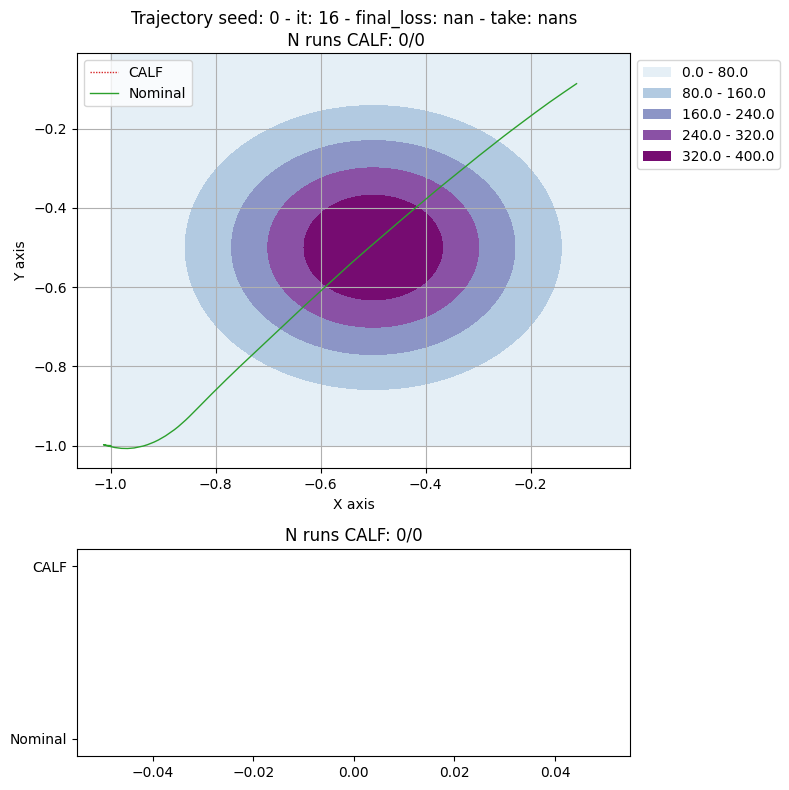

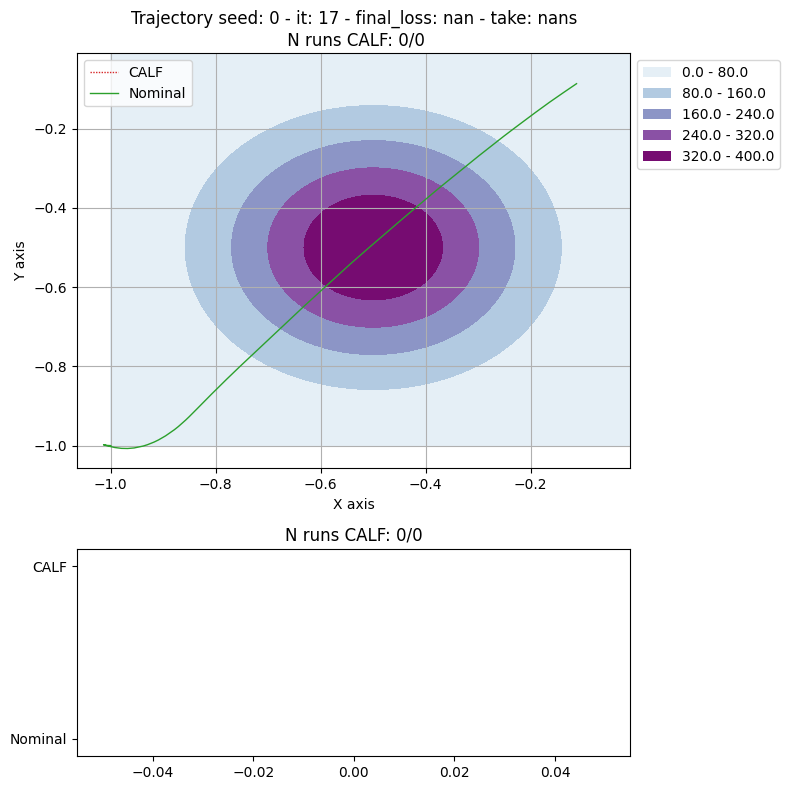

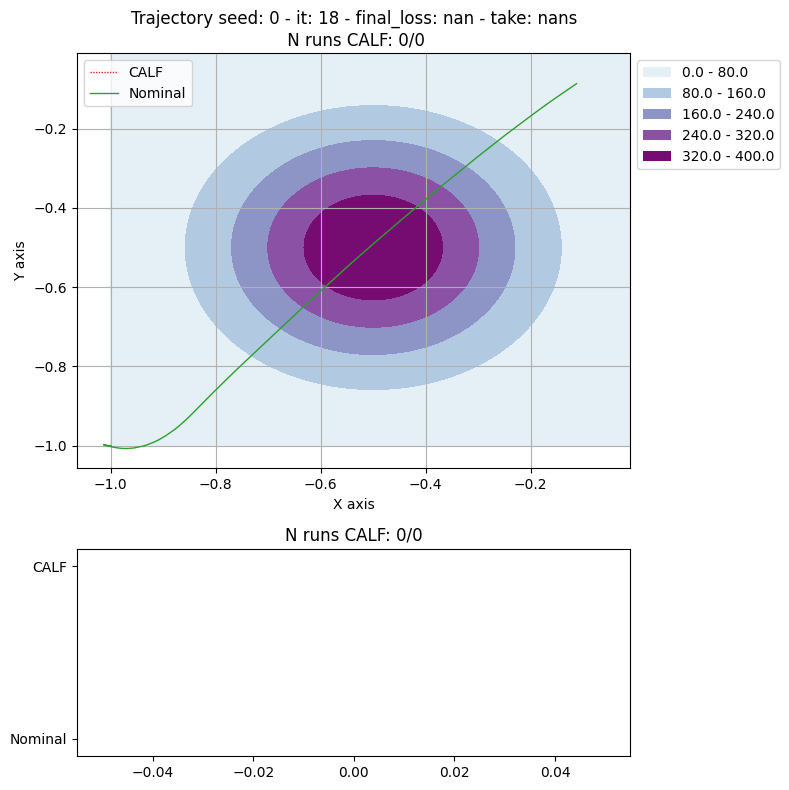

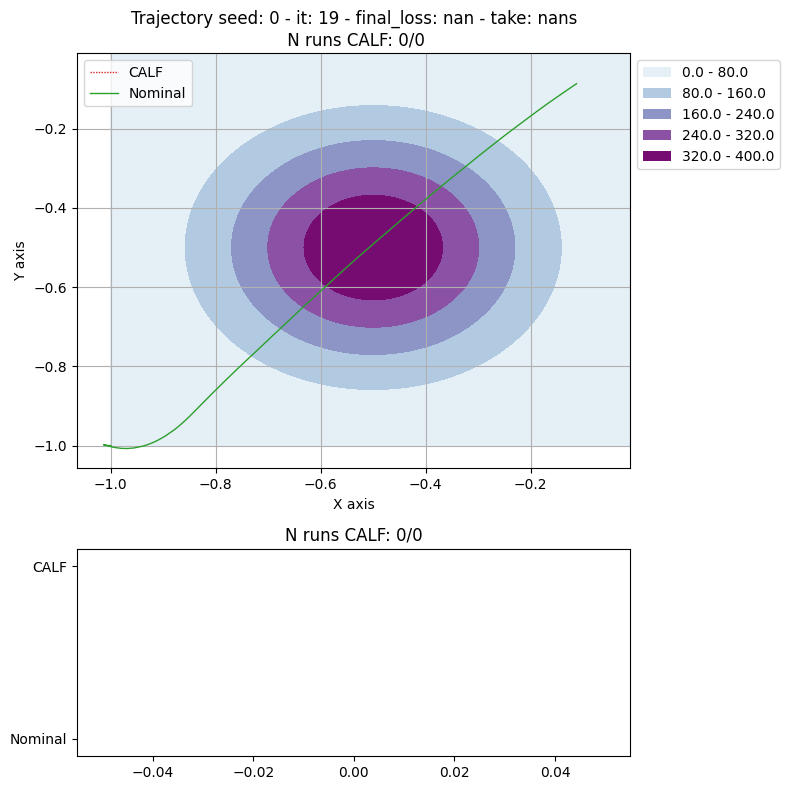

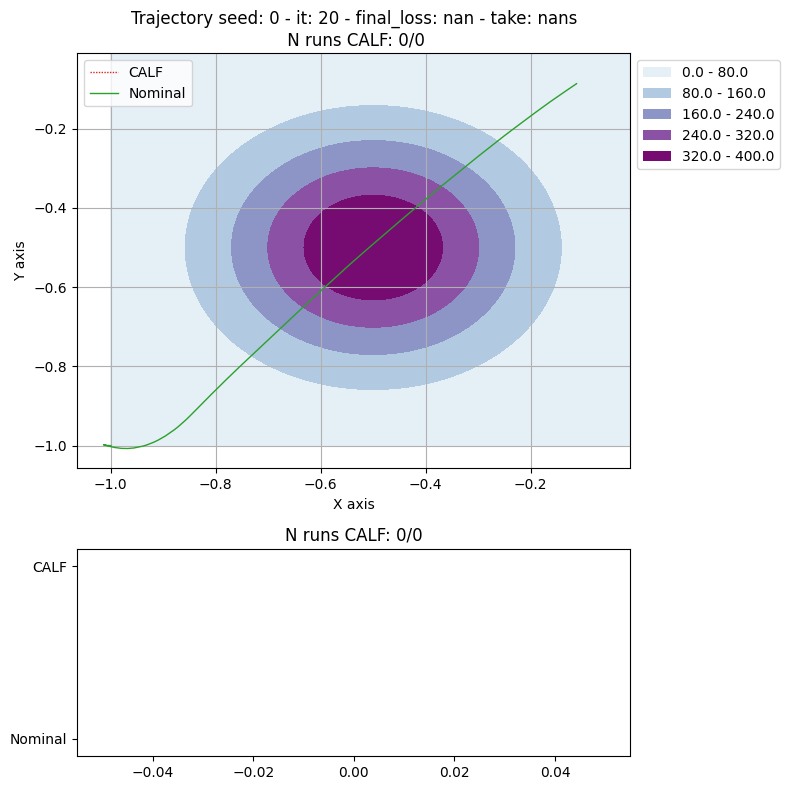

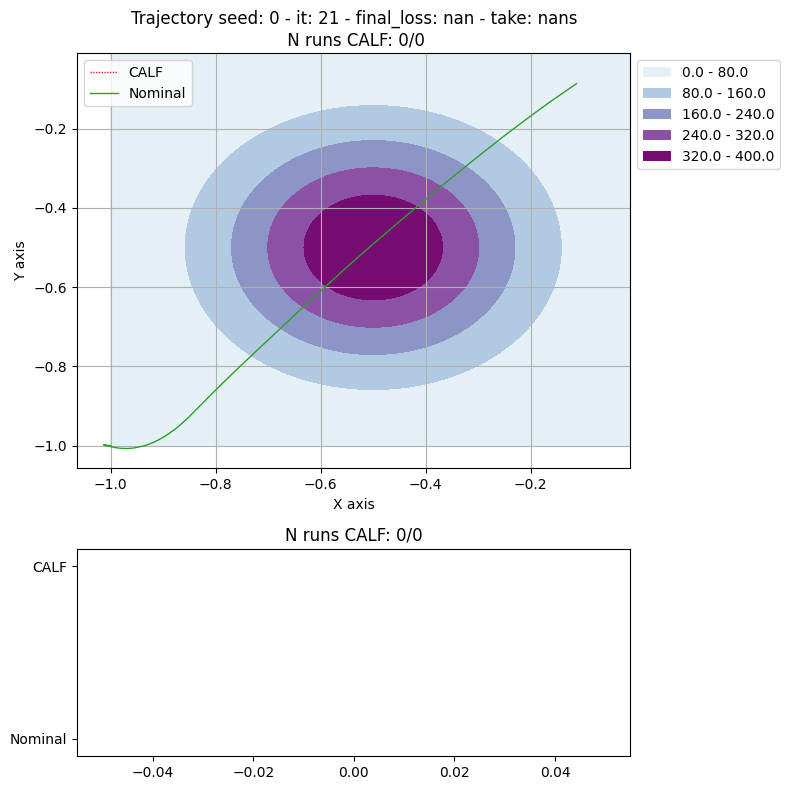

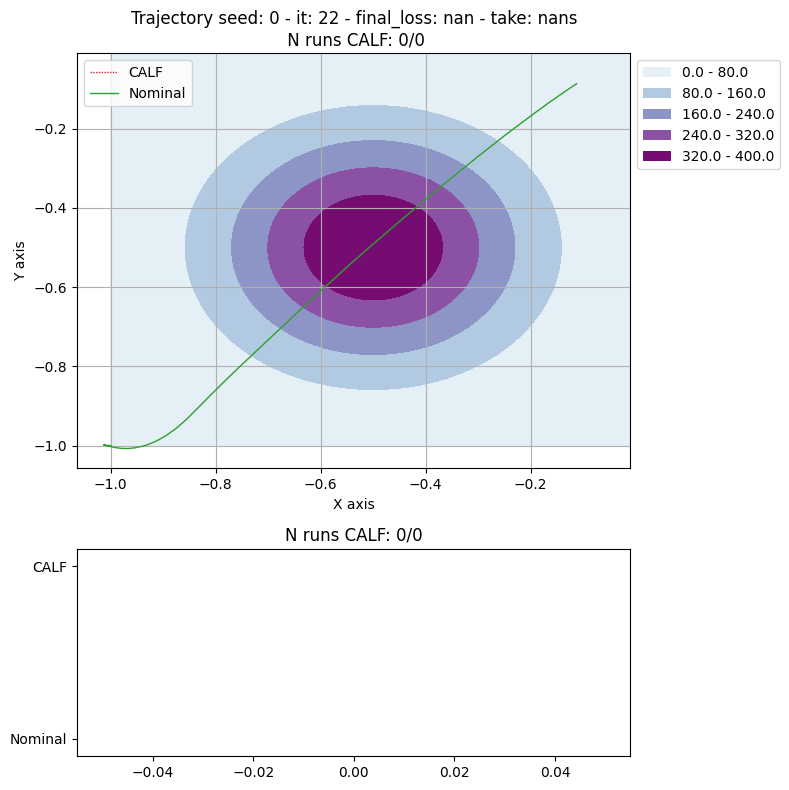

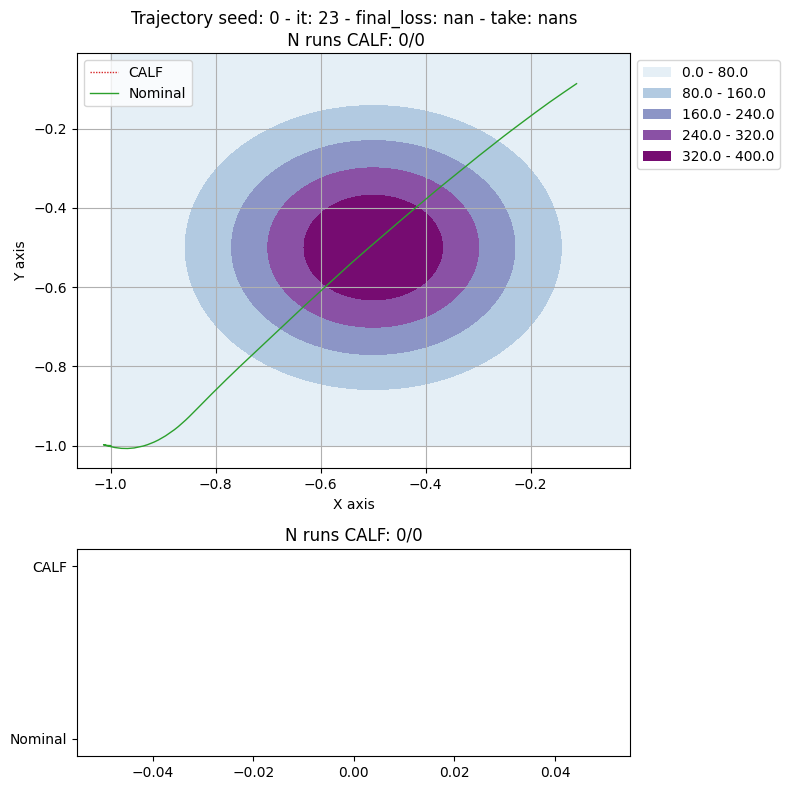

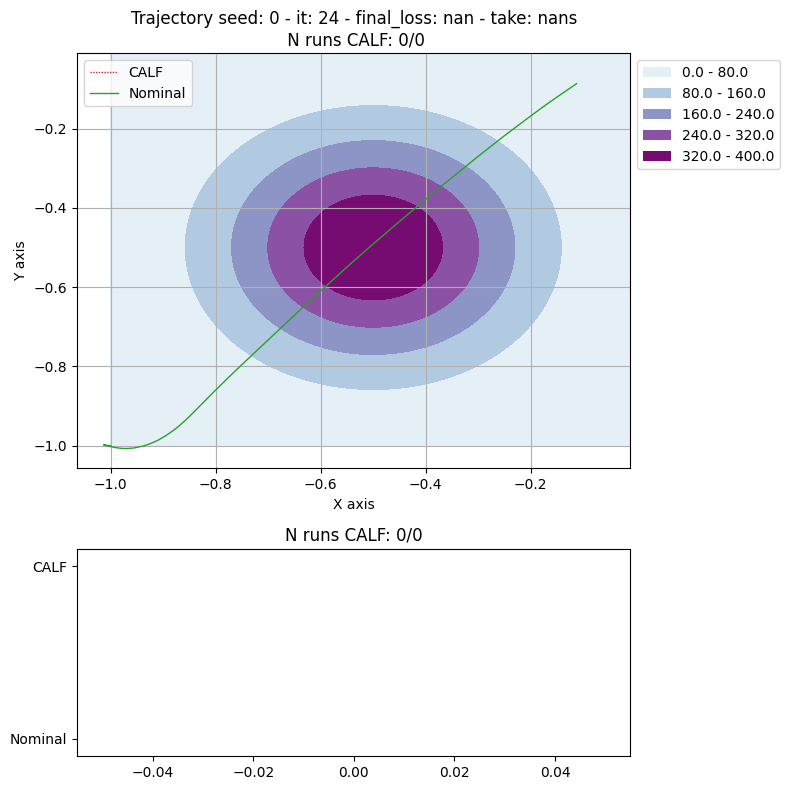

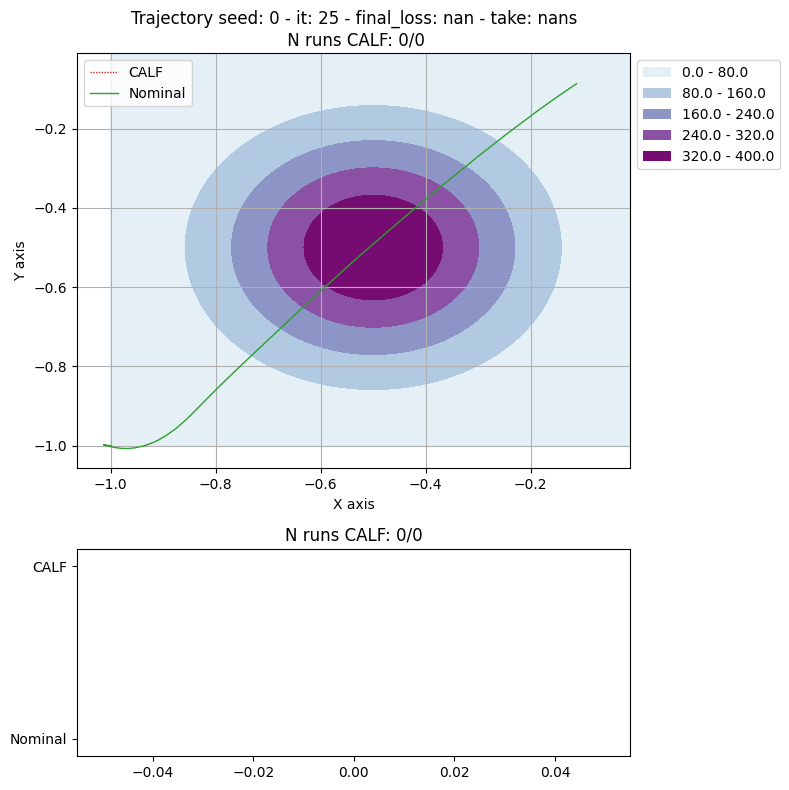

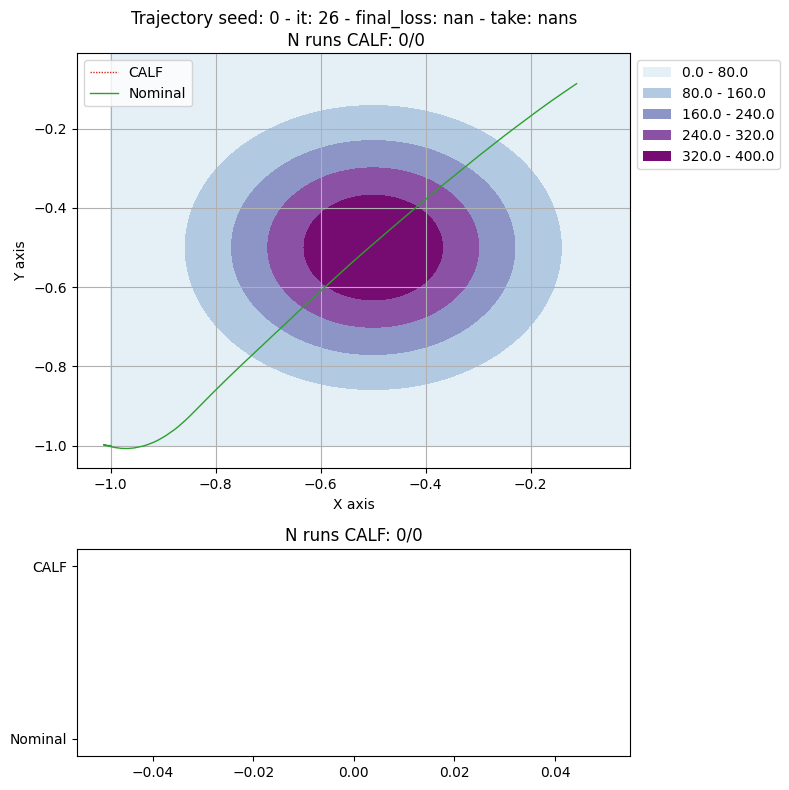

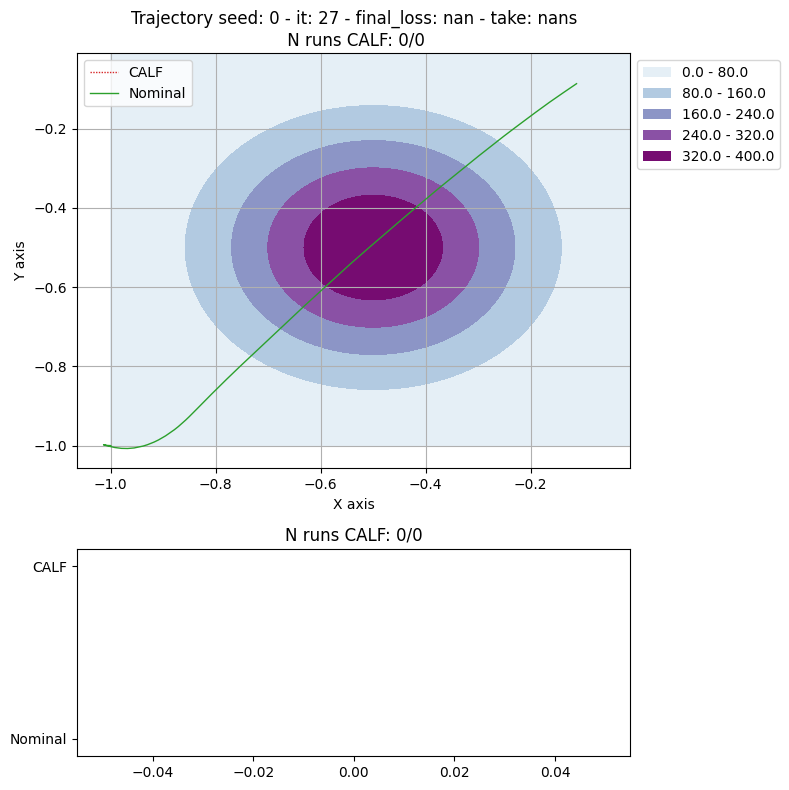

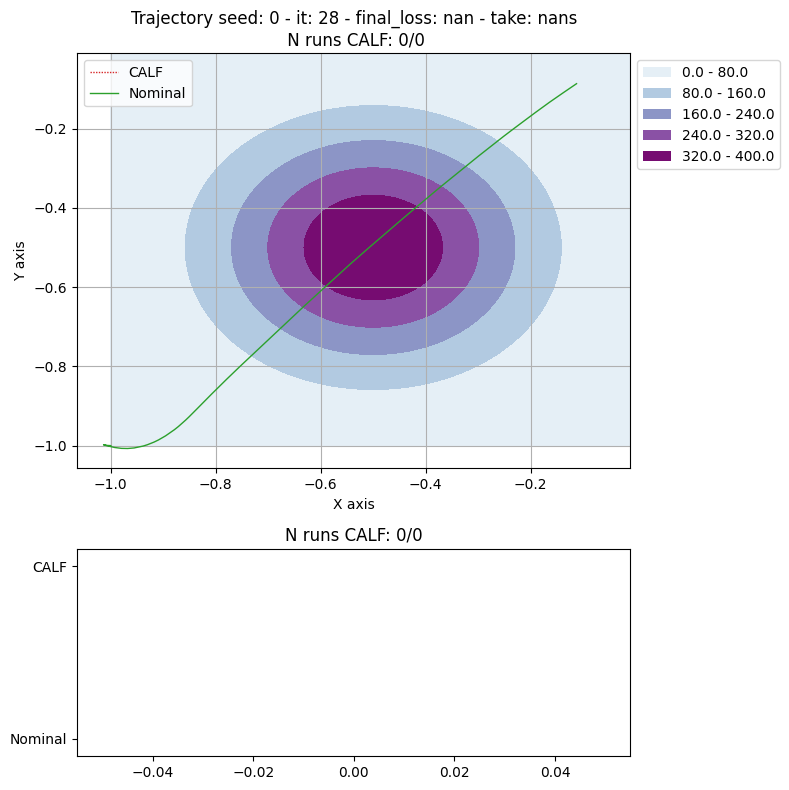

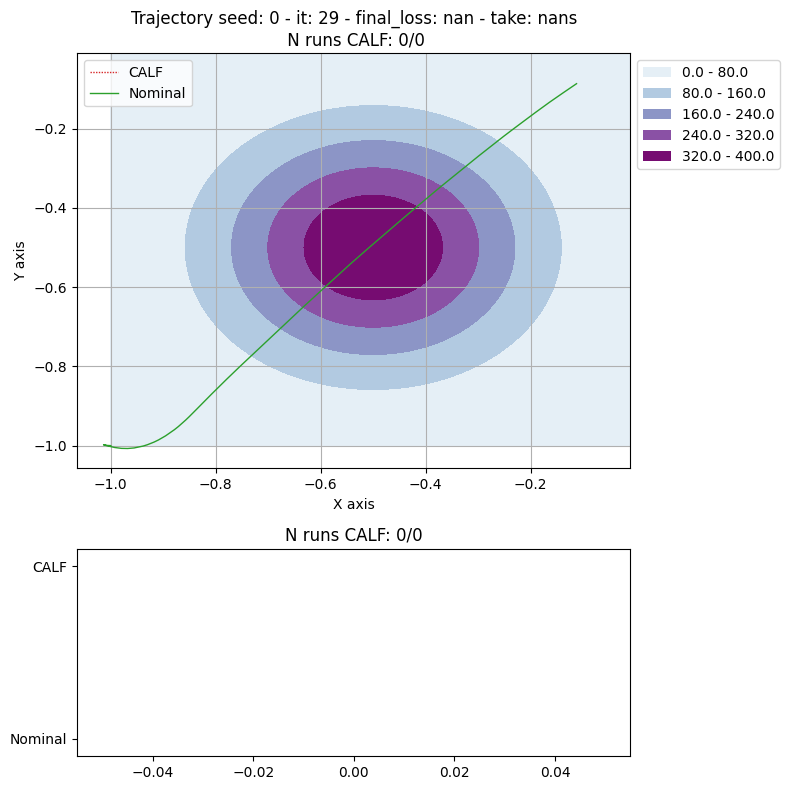

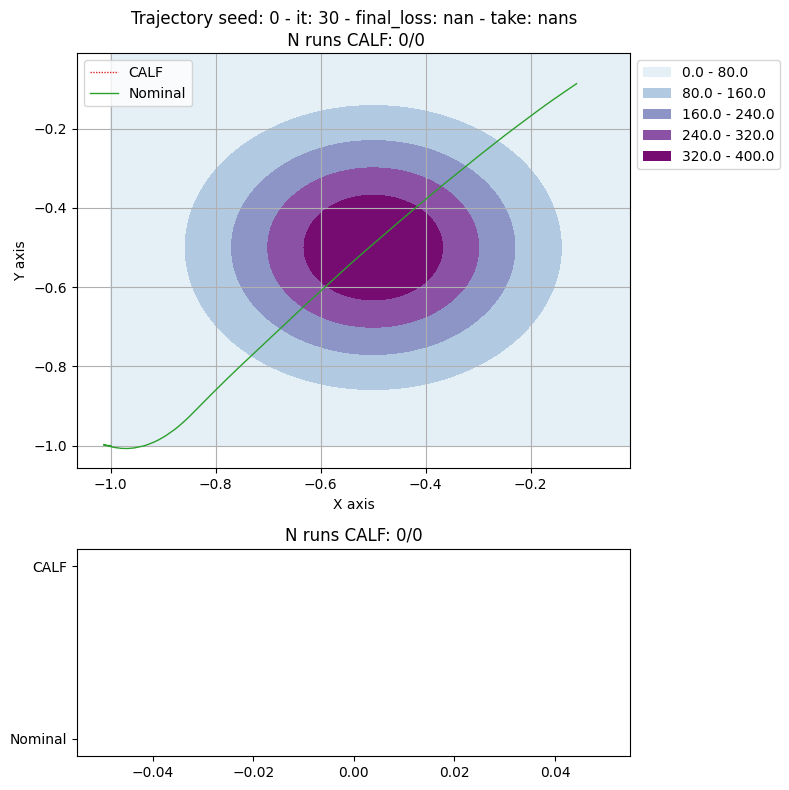

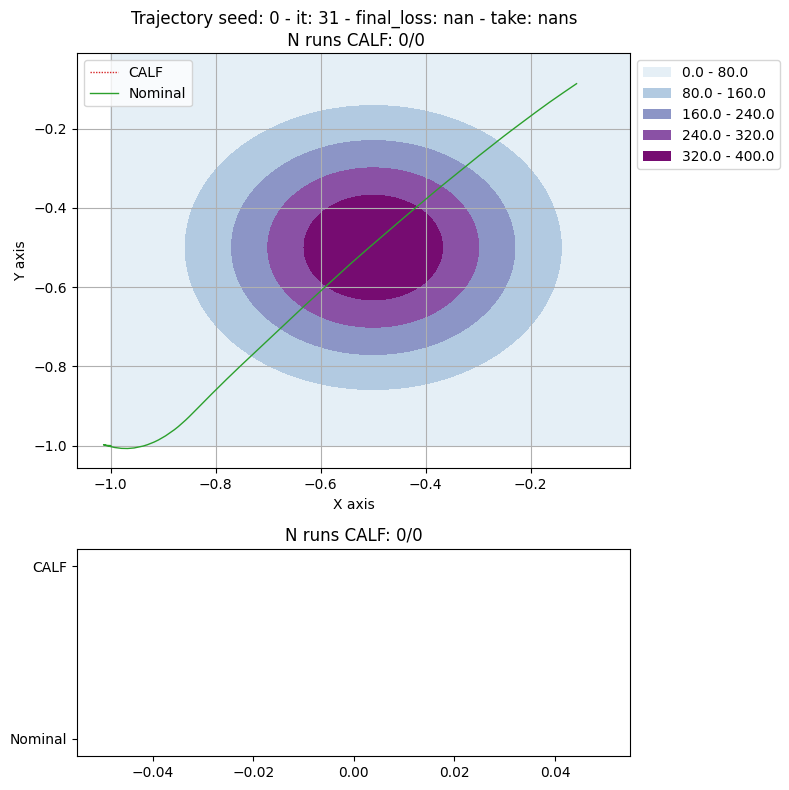

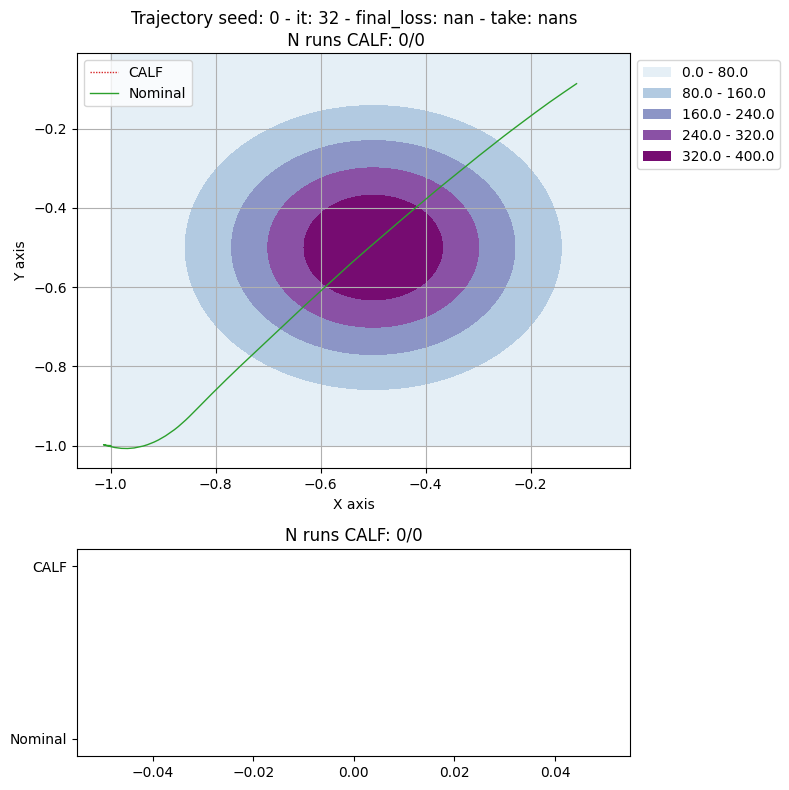

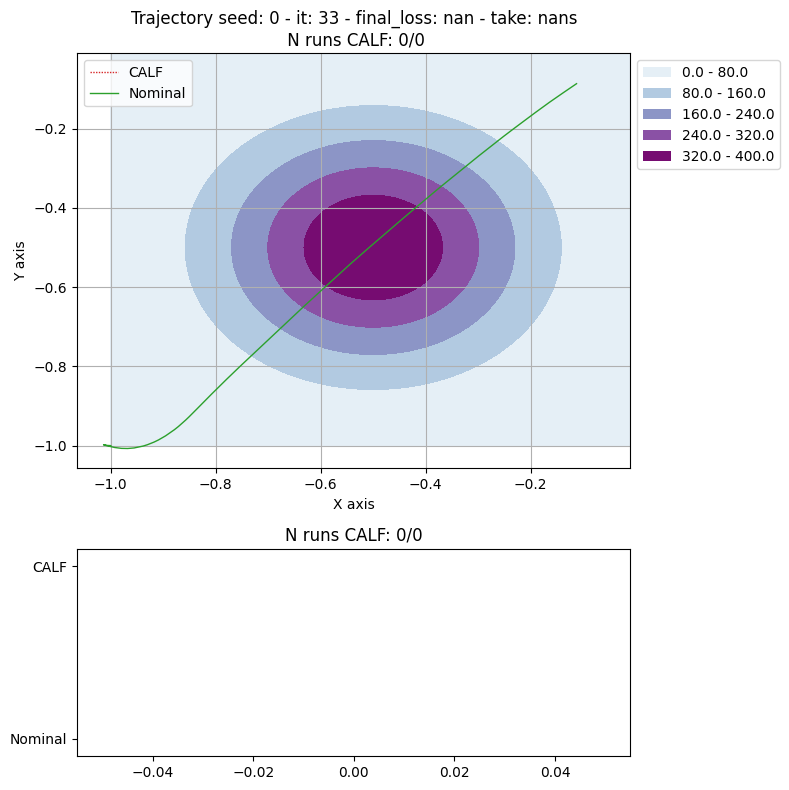

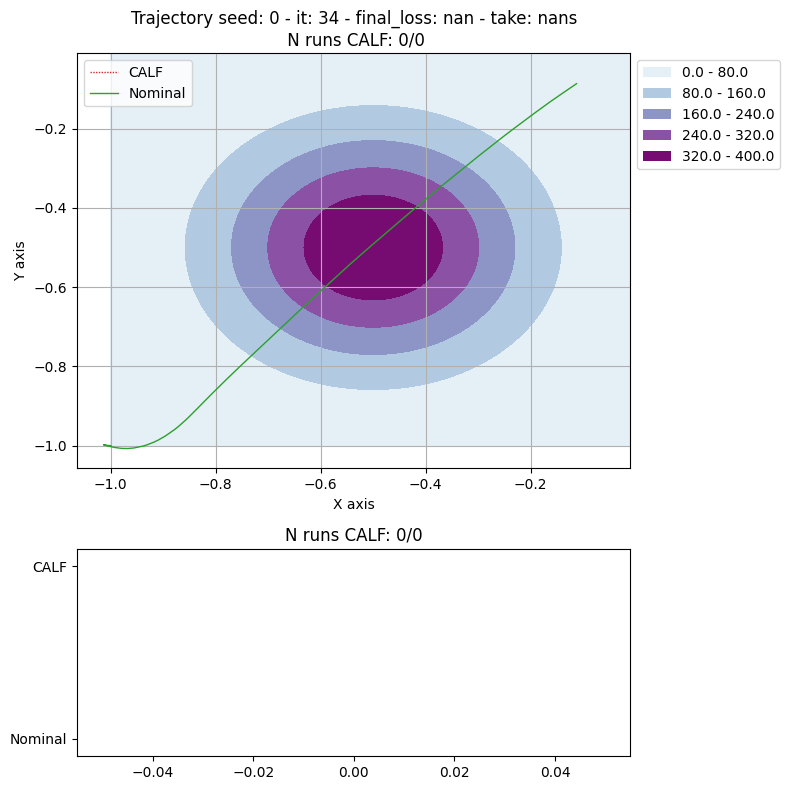

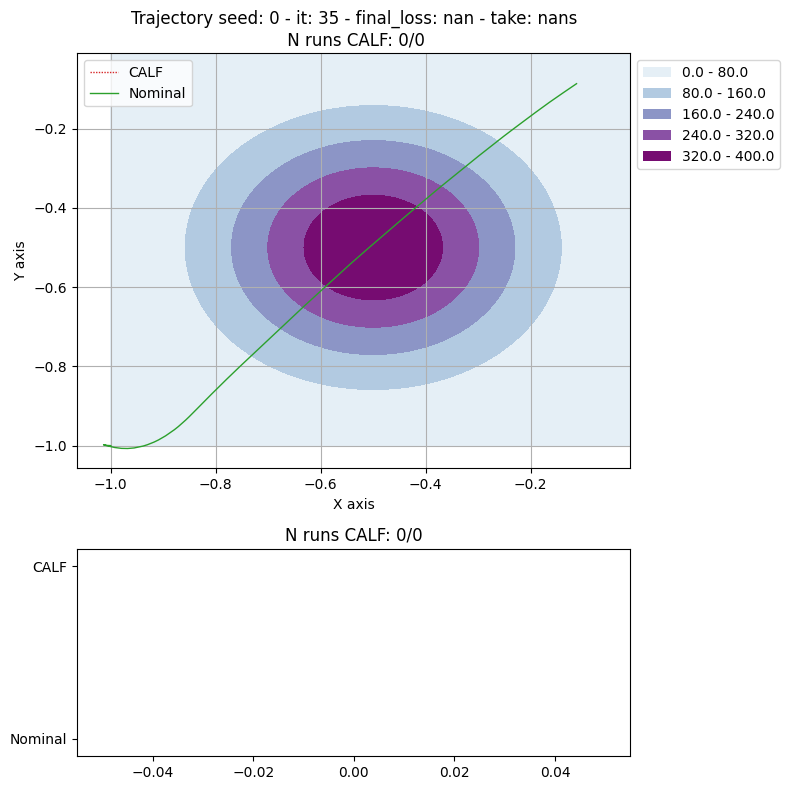

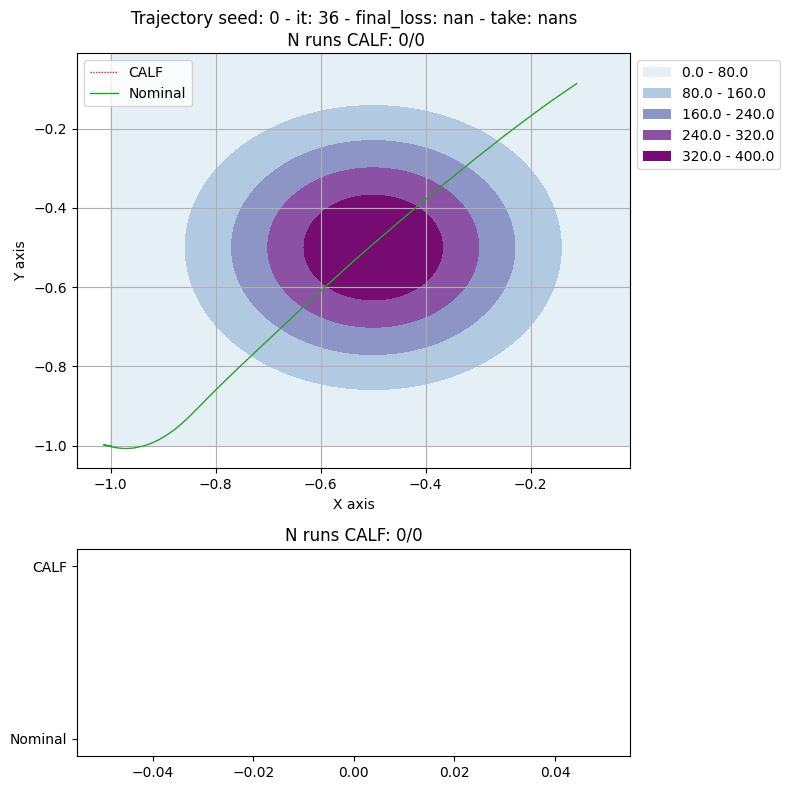

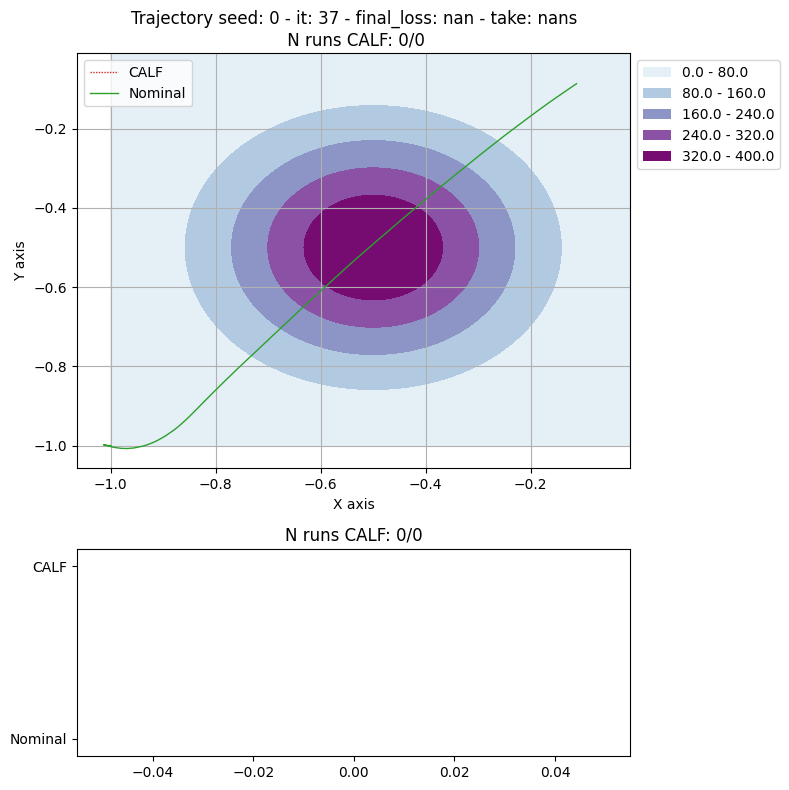

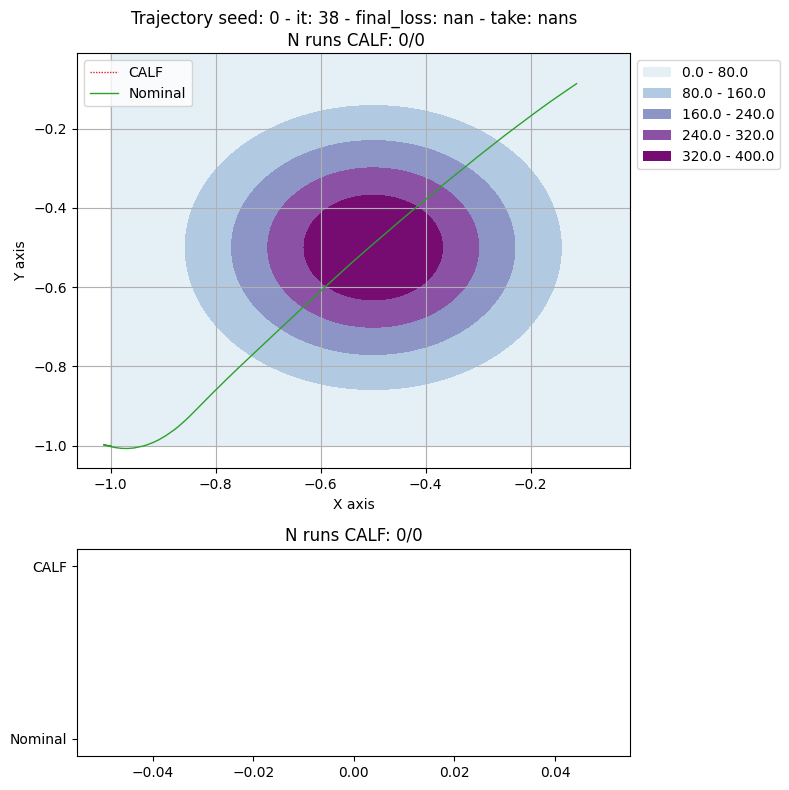

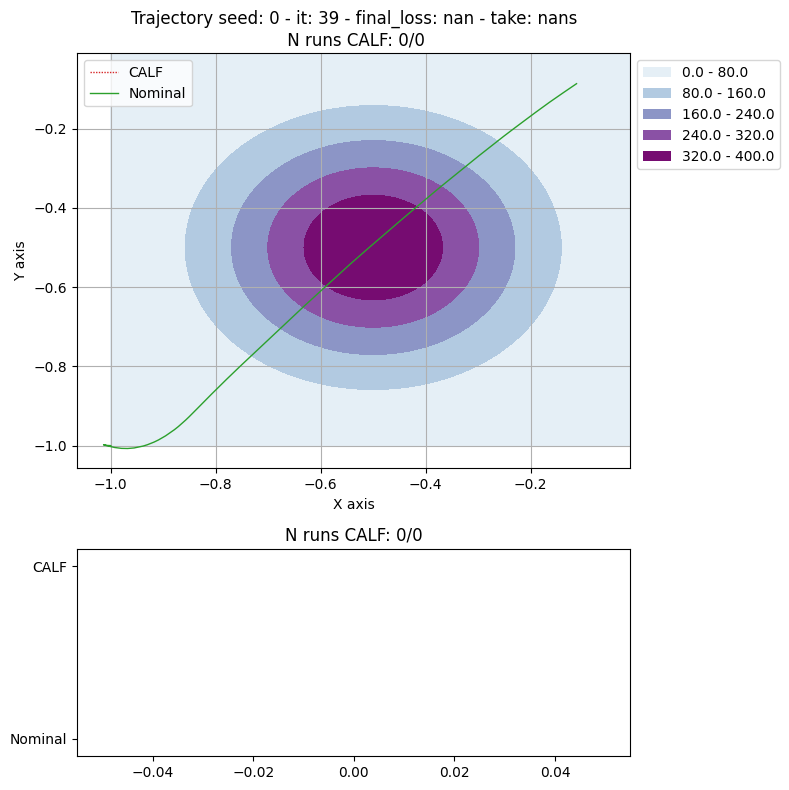

In [37]:
def plot_chosen_trajectory(df, it, seed=0, ref_df=None):
    fig, ax = plt.subplots(2, 1, sharey=False, figsize=(8, 8), height_ratios=[2, 1])

    cs = ax[0].contourf(X, Y, Z, alpha=1, levels=5, cmap="BuPu")
    cs.cmap.set_over('red')
    cs.cmap.set_under('blue')
    cs.changed()

    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in cs.collections]

    sub_df_1 = df[df["seed"] == str(seed)]
    sub_df_2 = sub_df_1[sub_df_1["iteration_id"] == it]
    ax[0].plot(sub_df_2["x [m]"], sub_df_2["y [m]"], 
            linestyle=linestyle_dict[style[1]],
            lw=1, 
            color=colors[5] if sub_df_2["iteration_id"].max() <= sub_df_1["iteration_id"].max() - 5 else colors[50], 
            alpha=1,
            label="CALF")

    ax[0].set_title("Trajectory seed: {} - it: {} - final_loss: {:.2f} - take: {:.2f}s\n N runs CALF: {}/{}".format(
                    seed, 
                    it, 
                    sub_df_2["running_objective"].max(), 
                    sub_df_2["time"].max(),
                    sub_df_2["use_calf"].sum(),
                    sub_df_2["use_calf"].count()))
    
    ax[1].plot(sub_df_2["time"], sub_df_2["use_calf"])
    ax[1].set_ylim([-0.1, 1.1])
    ax[1].set_yticks([0, 1], ["Nominal", "CALF"])
    ax[1].set_title("N runs CALF: {}/{}".format(
        sub_df_2["use_calf"].sum(),
        sub_df_2["use_calf"].count()
    ))

    if ref_df is not None:
        ax[0].plot(ref_df["x [m]"], ref_df["y [m]"], 
                linestyle=linestyle_dict[style[5]],
                lw=1, 
                color=colors[10], 
                alpha=1,
                label="Nominal")

    traj_legend = ax[0].legend()
    ax[0].legend(proxy, 
                 [f"{cs.levels[l_i-1]} - {cs.levels[l_i]}" for l_i in range(1, len(cs.levels))],
                 bbox_to_anchor=(1, 1))

    ax[0].set_xlabel('X axis')
    ax[0].set_ylabel('Y axis')
    
    ax[0].add_artist(traj_legend)
    # Show the plot
    ax[0].grid(True)
    plt.tight_layout()
    fig.savefig("media/trajectories_with_ref.svg", dpi=fig.dpi)

# plot_chosen_trajectory(clean_df, ref_df=ref_df, it=16, seed=7)
# plot_chosen_trajectory(clean_df, ref_df=ref_df, it=1, seed=6)

for i in range(1, 40):
    plot_chosen_trajectory(concat_df, ref_df=ref_df, it=i, seed=0)

# plot_chosen_trajectory(concat_df, ref_df=ref_df, it=29, seed=0)

/tmp/ipykernel_61581/4202083651.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()


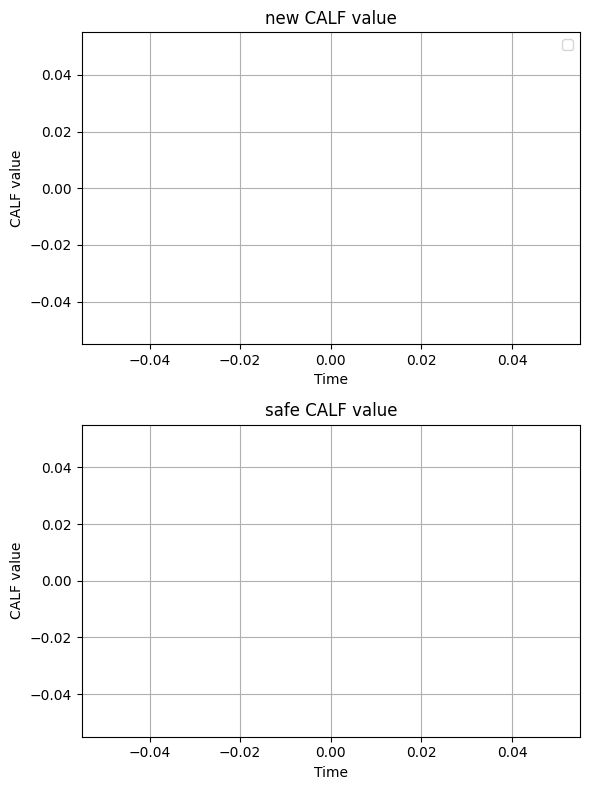

In [38]:
def plot_chosen_calf_value(df, it, seed=0):
    fig, ax = plt.subplots(2, 1, sharey=False, figsize=(6, 8), height_ratios=[1, 1])

    # cs = ax[0].contourf(X, Y, Z, alpha=1, levels=5, cmap="BuPu")
    # cs.cmap.set_over('red')
    # cs.cmap.set_under('blue')
    # cs.changed()

    # proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in cs.collections]

    sub_df_1 = df[df["seed"] == str(seed)]
    sub_df_2 = sub_df_1[sub_df_1["iteration_id"] == it]
    ax[0].plot(sub_df_2["time"], sub_df_2["critic_new"])
    ax[0].set_title("new CALF value")
    
    ax[1].plot(sub_df_2["time"], sub_df_2["critic_safe"], label="safe CALF value")
    ax[1].set_title("safe CALF value")

    ax[0].legend()
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('CALF value')
    ax[0].grid(True)

    ax[1].grid(True)
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('CALF value')
    plt.tight_layout()
    fig.savefig("media/CALF_value.svg", dpi=fig.dpi)

# plot_chosen_calf_value(concat_df, it=16, seed=7)
# plot_chosen_calf_value(concat_df, it=1, seed=6)
plot_chosen_calf_value(concat_df, it=21, seed=0)

# Choose best runs

In [39]:
# concat_df.loc[:, ["seed", "iteration_id", "current_value", "dis_2_goal"]].groupby(["seed", "iteration_id"]).agg("max").sort_values(by="current_value").head(10)

filter_on_target_df(concat_df)
concat_df.iteration_id.unique()

array([1])

In [40]:
import numpy as np

file_path = "regelum_data/outputs/2024-07-25/15-34-05/5/.callbacks/PolicyNumpyModelSaver/model_it_00008.npy"
np.load(file_path)

FileNotFoundError: [Errno 2] No such file or directory: 'regelum_data/outputs/2024-07-25/15-34-05/5/.callbacks/PolicyNumpyModelSaver/model_it_00008.npy'